#0

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,mean_squared_log_error,r2_score,make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import KBinsDiscretizer,StandardScaler,Normalizer,FunctionTransformer,OneHotEncoder,OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression,SGDRegressor,LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.multiclass import OneVsRestClassifier

#1

##1

Caricare il dataset introducendo un opportuno nome per le colonne e denominarlo con una
variabile chiamata “dataset”

In [188]:
dataset=pd.read_csv("weather.csv",sep=';')
#i nomi delle colonne ci sono già

In [189]:
dataset.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1,Albury,20.4,37.6,0.0,54,0,7,46,17,1013.4,1009.2,3,26.1,36.7,No,No
1,1,Albury,20.9,33.6,0.4,50,9,17,54,30,1011.1,1008.4,8,24.8,31.7,No,Yes
2,1,Albury,18.4,23.1,2.2,48,11,39,62,67,1014.0,1014.8,8,21.8,19.5,Yes,Yes
3,1,Albury,17.3,23.7,15.6,39,9,17,74,65,1017.9,1016.5,8,19.2,21.6,Yes,Yes
4,1,Albury,15.5,22.9,6.8,31,6,9,92,63,1016.3,1013.9,8,17.2,22.2,Yes,No


##2

Quante sono le istanze contenute nel dataset? _______ Il dataset è completo (cioè non
esistono valori nulli)? _______ Il dataset è bilanciato per quanto riguarda la classe da predire?  
_______ Il numero di rilevazioni per città è bilanciato? _______

In [190]:
#numero istanze:
dataset.shape[0]

14468

In [191]:
#check valori nulli
dataset.isnull().any().any()
#non ci sono valori nulli, quindi SI

False

In [192]:
#check se la classe è bilanciata
dataset['RainTomorrow'].value_counts()
#NON è bilanciata. la classe "no" è circa 3x la classe "si"

,count
RainTomorrow,
No,11038
Yes,3430


In [193]:
#check se rilevazioni per città è bilanciato
print("media rilevazioni: ",dataset['Location'].value_counts().mean())
dataset['Location'].value_counts().sort_values()
#ordinando per rilevazioni crescenti, si vede che per le prime 5/6 c'è un po' di sbilanciamento, le altre
#invece hanno un num di rilevazioni intorno la media

media rilevazioni:  344.4761904761905


,count
Location,
Melbourne,245
Cobar,260
Cairns,295
Williamtown,300
GoldCoast,306
Moree,312
NorfolkIsland,326
Walpole,327
Uluru,332


##3

Rappresentare in un grafico la frequenza delle rilevazioni mensili per città

<Axes: xlabel='Location'>

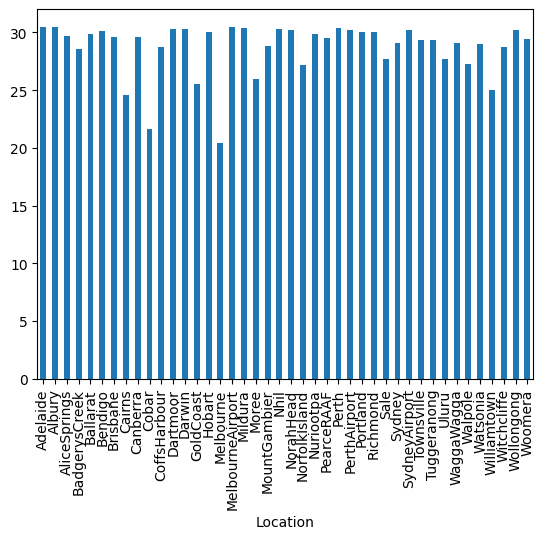

In [194]:
freq=dataset.groupby(["Location"])['Month'].count()/12
#faccio la media delle rilevazioni mensili sommando tutte le rilevazioni e divido per 12 mesi
freq.plot.bar()

##4

Calcolare per ogni città e per ogni mese l’umidità minima e la massima

In [195]:
dataset.groupby(['Location','Month'])[['Humidity9am','Humidity3pm']].max().max(axis=1)

Location  Month
Adelaide  1        93
          2        76
          3        93
          4        84
          5        93
                   ..
Woomera   8        92
          9        95
          10       92
          11       76
          12       81
Length: 497, dtype: int64

In [196]:
dataset.groupby(['Location','Month'])[['Humidity9am','Humidity3pm']].min().min(axis=1)

Location  Month
Adelaide  1        11
          2        13
          3        19
          4        15
          5        32
                   ..
Woomera   8        13
          9        15
          10        4
          11        3
          12        7
Length: 497, dtype: int64

##5

Creare un nuovo attributo “TemperatureRange” che mostri l’escursione termica giornaliera.
Rappresentare in un grafico l’escursione massima mensile.

<Axes: xlabel='Month'>

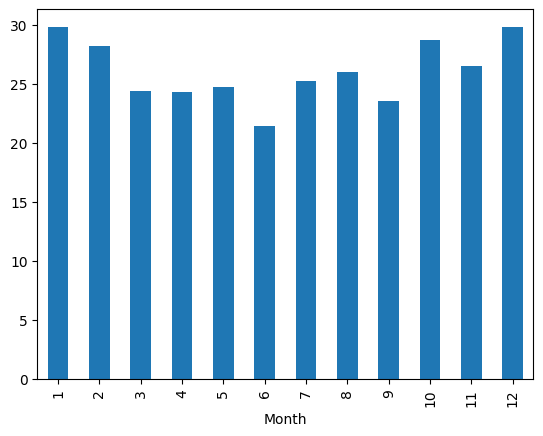

In [197]:
dataset['TemperatureRange']=dataset['MaxTemp']-dataset['MinTemp']
#creo nuovo attributo
dataset.groupby('Month')['TemperatureRange'].max().plot.bar()
#plotto il massimo delle escursioni diviso per mese

#2

##1

Si vuole predire la possibilità di avere pioggia il giorno successivo (RainTomorrow è la classe
da predire).
Trasformare i valori degli attributi RainToday e RainTomorrow da No a 0, e da Yes a 1.
Creare un nuovo dataset chiamato reduce con le istanze del dataset per le quali c’è un valore di
Cloud3pm maggiore o uguale a 0.
Dividere il dataset in modo che 4/5 degli elementi siano contenuti in un nuovo dataset “train” e
1/5 in un  dataset “test”.
Valutare l’accuracy ottenuta con il classificatore Logistic Regression e il Decision Tree

In [198]:
dataset['RainToday']=dataset['RainToday'].map({"Yes":1,"No":0})
dataset['RainTomorrow']=dataset['RainTomorrow'].map({"Yes":1,"No":0})
#convertiti i valori in 0/1

In [199]:
dataset['Location']=OrdinalEncoder().fit_transform(dataset[['Location']])

In [200]:
#creo nuovo dataset
reduced=dataset[dataset['Cloud3pm']>=0].copy()

In [201]:
X,y=reduced.drop("RainTomorrow",axis=1),reduced['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=0,test_size=1/5)
#divido in dataset di train e test

In [202]:
#alleno logreg e tree:
lr=LogisticRegression(random_state=0,solver='liblinear')
dt=DecisionTreeClassifier(random_state=0)
lr.fit(X_train,y_train)
dt.fit(X_train,y_train)
y_lr=lr.predict(X_test)
y_dt=dt.predict(X_test)

In [203]:
print("--confronto accuracies su train--")
print("accuracy train logistic regression: ",accuracy_score(lr.predict(X_train),y_train))
print("accuracy train decision tree: ",accuracy_score(dt.predict(X_train),y_train))
#capacità di imparare il dataset

--confronto accuracies su train--
accuracy train logistic regression:  0.8110861423220974
accuracy train decision tree:  1.0


In [204]:
print("--confronto accuracies su test--")
print("accuracy train logistic regression: ",accuracy_score(lr.predict(X_test),y_test))
print("accuracy train decision tree: ",accuracy_score(dt.predict(X_test),y_test))
#=capacità di generalizzare. il logistic regression ha performance costanti sia su train che su test, mentre
#l'albero evidenzia che sta ricalcando un po' troppo il dataset di train

--confronto accuracies su test--
accuracy train logistic regression:  0.8178550029958058
accuracy train decision tree:  0.7597363690832835


In [205]:
print("--confronto conf matrix su train--")
print("cm train logistic regression: \n",confusion_matrix(lr.predict(X_train),y_train))
print("cm train decision tree: \n",confusion_matrix(dt.predict(X_train),y_train))
#notiamo che il tree impara alla perfezione mentre logreg confrone un po,
#circa 400 elementi sono della classe 1 ma vengono predetti come 0

--confronto conf matrix su train--
cm train logistic regression: 
 [[4420  882]
 [ 379  994]]
cm train decision tree: 
 [[4799    0]
 [   0 1876]]


In [206]:
print("--confronto conf matrix su test--")
print("cm train logistic regression: \n",confusion_matrix(lr.predict(X_test),y_test))
print("cm train decision tree: \n",confusion_matrix(dt.predict(X_test),y_test))
#logreg mantiene performance come prima, 88 su 250 è intorno a un terzo come prima
#mentre si vede che il treee sbaglia molto ora

--confronto conf matrix su test--
cm train logistic regression: 
 [[1113  217]
 [  87  252]]
cm train decision tree: 
 [[990 191]
 [210 278]]


##2

Che valore di accuratezza si ottiene con un 5 Fold cross validation e il  classificatore basato su
Decision Tree  ________________ e quello basato su Logistic Regression ________________
Il valore di accuratezza maggiormente rappresentativo è quello che si ottiene con questa tecnica
o con quella attuata in precedenza? (

In [207]:
cross_val_score(DecisionTreeClassifier(random_state=0),X,y,cv=5).mean()
#il decision tree dimostra di avere performance costanti. sembra stia ricalcando troppo il dataset di train

0.7295055267948614

In [208]:
cross_val_score(LogisticRegression(solver='liblinear',random_state=0),X,y,cv=5).mean()
#performance costanti per logreg, che funziona molto meglio

0.807883495480428

In [209]:
#il valore migliore lo si ottiene con questa tecnica, dato che col train potrebbe essere che si ha del
#bias dovuto al campionamento

##3

Si introduca un attributo che sostituisca per ogni rilevazione i due valori di temperatura
“MinTemp, MaxTemp” con il valore medio delle registrazioni. Si faccia lo stesso con vento
(WindSpeed9am, WindSpeed3pm). Che valore di accuratezza si ottiene? ________________

In [210]:
#inserisco direttamente nel dataset originale poi splitto nuovamente
reduced['Temp']=(reduced['MaxTemp']-reduced['MinTemp'])/2
reduced['Wind']=(reduced['WindSpeed9am']-reduced['WindSpeed3pm'])/2
reduced.drop(['MaxTemp','MinTemp','WindSpeed9am','WindSpeed3pm'],axis=1,inplace=True)
X,y=reduced.drop("RainTomorrow",axis=1),reduced['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=0,test_size=1/5)

In [211]:
#modelli
lr=LogisticRegression(random_state=0,solver='liblinear')
dt=DecisionTreeClassifier(random_state=0)
lr.fit(X_train,y_train)
dt.fit(X_train,y_train)
y_lr=lr.predict(X_test)
y_dt=dt.predict(X_test)

In [212]:
print("--confronto accuracies su train--")
print("accuracy train logistic regression: ",accuracy_score(lr.predict(X_train),y_train))
print("accuracy train decision tree: ",accuracy_score(dt.predict(X_train),y_train))
print("--confronto accuracies su test--")
print("accuracy train logistic regression: ",accuracy_score(lr.predict(X_test),y_test))
print("accuracy train decision tree: ",accuracy_score(dt.predict(X_test),y_test))

#il logistic regression si conferma avere performance stabili intorno a 0.81
#il tree pure intorno a 0.76

--confronto accuracies su train--
accuracy train logistic regression:  0.807940074906367
accuracy train decision tree:  1.0
--confronto accuracies su test--
accuracy train logistic regression:  0.8154583582983823
accuracy train decision tree:  0.7681246255242661


##4

Si riparta dal dataset originario e si considerino due nuovi dataset ottenuti rimuovendo dal
dataset di partenza gli elementi con Cloud3pm minore di 0. Il dataset con i valori negativi si
chiamerà cloudP, l’altro cloudT.
Si alleni un regressore su cloudT per predire i valori di Cloud3pm. Si usi il modello per sostituire
in cloudP il valore predetto per Cloud3pm.

In [157]:
#ricarico dataset


In [221]:
cloudP=dataset[dataset['Cloud3pm']<0].copy()
cloudT=dataset[dataset['Cloud3pm']>=0].copy()

In [229]:
cloudP['Cloud3pm'].value_counts()

,count
Cloud3pm,
1,3012
8,2115
7,901
0,70
6,24
2,1
4,1


In [223]:
#devo allenarlo su cloudT e fargli predire i valori di cloudP
lr.fit(cloudT.drop("Cloud3pm",axis=1),cloudT['Cloud3pm'])
cloudP['Cloud3pm']=lr.predict(cloudP.drop("Cloud3pm",axis=1))

##5

Si consideri il dataset ottenuto concatenando cloudP e cloudT in un unico dataset e si
confronti l’accuratezza che si ottiene con un 10 Fold cross validation e il  classificatore basato su
Decision Tree  e quello basato su Logistic Regression con quella ottenuta al punto 3. (punti 3)

In [230]:
cloud_new=pd.concat([cloudP,cloudT])
#concateno tutto

In [231]:
#cv 10
cross_val_score(DecisionTreeClassifier(random_state=0),cloud_new.drop("RainTomorrow",axis=1),cloud_new['RainTomorrow'],cv=10).mean()

0.7194540906401474

In [232]:
cross_val_score(LogisticRegression(random_state=0,solver='liblinear'),cloud_new.drop("RainTomorrow",axis=1),cloud_new['RainTomorrow'],cv=10).mean()

0.8249229339856106

In [ ]:
#le performance del tree circa sempre 0.72 come nel punto 2

##6

 Utilizzare un algoritmo di regressione da applicarsi al dataset del punto 1 per effettuare la
predizione. Arrotondare i valori predetti  all’intero. Confrontare i risultati ottenuti con quelli
ottenuti nei punti precedenti

In [238]:
lin=LinearRegression()
X,y=reduced.drop("RainTomorrow",axis=1),reduced['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=0,test_size=1/5)
lin.fit(X_train,y_train)

LinearRegression()

In [243]:
y_ptrain=np.rint(lin.predict(X_train))
y_ptest=np.rint(lin.predict(X_test))
#gli faccio predirre e arrotondiamo all'intero più vicino

In [245]:
print("--confronto accuracies su train--")
print("accuracy train logistic regression: ",accuracy_score(y_ptrain,y_train))
print("--confronto accuracies su test--")
print("accuracy train logistic regression: ",accuracy_score(y_ptest,y_test))

--confronto accuracies su train--
accuracy train logistic regression:  0.8058426966292135
--confronto accuracies su test--
accuracy train logistic regression:  0.8076692630317556


In [ ]:
#le performance sono leggermente calate essendo un'approssimazione. tuttavia essendo che il logreg si basa sul
#modello lineare allora funzionano abbastanza simili